In [147]:
from typing import List
import sys
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/neuroforest-master')
sys.path.append('C:/Users/TomFi/Desktop/Cours/Projet IA/deepHL')
import numpy as np
import random as rd
import json
import os
import time
from tqdm import tqdm
from IPython import display
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import MinMaxScaler


from main import to_vect, Coordinates, calculate_asrs, classify_asrs, dataloader, dataloader_2024
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary


In [148]:
def create_batches(dataloader, session_type: str, batch_size: int, scale : int = 20,
                   subsample : bool = False, asrs_calc = classify_asrs, augmentation : bool = False, shuffle : bool = True):
    trajectories = []
    asrs = []
    print("Iterating through dataloader...")
    for sample in tqdm(dataloader):
        session = sample[session_type]
        if session is not None:
            if sample.answers is not None:
                player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])
                player_coords = player_coords[:, [0, 2]]  # Keep only x and z coordinates
                asrs_score = asrs_calc(sample.answers)
                if augmentation:
                    # Add 8 different rotations of the trajectory
                    for i in range(0, 8):
                        # rotate from 45°
                        theta = np.radians(45*i)
                        c, s = np.cos(theta), np.sin(theta)
                        R = np.array([[c, -s], [s, c]])
                        rotated_coords = np.dot(player_coords, R)
                        trajectories.append(rotated_coords)
                        asrs_std = 3.1191546250994713
                        ICC = 0.75
                        intraclass_var = asrs_std**2 * (1/ICC - 1)
                        simulated_asrs = rd.gauss(asrs_score, intraclass_var)
                        asrs.append(simulated_asrs)

                else :
                    trajectories.append(player_coords)
                    asrs.append(asrs_score)

    # Pad / Truncate trajectories
    length = 30000
    padded_trajectories = []
    for traj in trajectories:
        if len(traj) < length:
            padded_traj = np.pad(traj, ((0, length - len(traj)), (0, 0)), mode='edge')
        else :
            padded_traj = traj
        truncated_traj = padded_traj[:length]
        padded_trajectories.append(truncated_traj)

    # Subsample trajectories
    if subsample:
        length = length // scale
        trajectories = np.array([np.array_split(player_coords, scale) for player_coords in padded_trajectories])
        trajectories = np.concatenate(trajectories, axis=0)
        trajectories = [coords - coords[0] for coords in trajectories]
        asrs = np.array([asrs_score for asrs_score in asrs for _ in range(scale)])
    else:
        trajectories = list(padded_trajectories)  

    # Shuffle trajectories
    tensor_trajectories = torch.tensor(list(trajectories), dtype=torch.float32)
    if shuffle :
        seed = 42
        permute = torch.randperm(len(tensor_trajectories), generator=torch.Generator().manual_seed(seed))
        tensor_trajectories = tensor_trajectories[permute]
        asrs = np.array(asrs)[permute]

    # Create batches
    num_batches = min(len(tensor_trajectories), len(asrs)) // batch_size
    if len(asrs) == len(trajectories):
        batches = tensor_trajectories[:num_batches * batch_size].view(num_batches, batch_size, length, 2)
        asrs = torch.tensor(np.array(asrs[:num_batches * batch_size])).view(num_batches, batch_size)
        # Reduce the sample rate
        batches = batches[:, :, ::25]    

    return batches, asrs

In [149]:
def data_setup(dataloader = dataloader, scale : int = 5, batch_size : int = 60, augmentation : bool = False,
               return_asrs : bool = False):
    # Create batches for "uniform" and "patchy" session types
    uniform_batches,asrs = create_batches(dataloader, "uniform", batch_size, subsample=True, asrs_calc = calculate_asrs, scale=scale, augmentation=augmentation)
    patchy_batches,asrs_2 = create_batches(dataloader, "patchy", batch_size, subsample=True, asrs_calc = calculate_asrs, scale=scale, augmentation=augmentation)
    asrs = torch.cat((asrs, asrs_2), 0)
    batches = torch.cat((uniform_batches, patchy_batches), 0)
    high_probability_adhd = torch.Tensor((np.array(asrs) >= 24).astype(int))

    print(f"Trajectory batches shape: {batches.shape}")
    print(f"Target batches shape: {high_probability_adhd.shape}")

    if return_asrs:
        return batches, asrs
    return batches, high_probability_adhd

# Test different scales

Creating batches...


  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:22<00:00,  1.73it/s]


Creating batches...


100%|██████████| 39/39 [00:21<00:00,  1.78it/s]


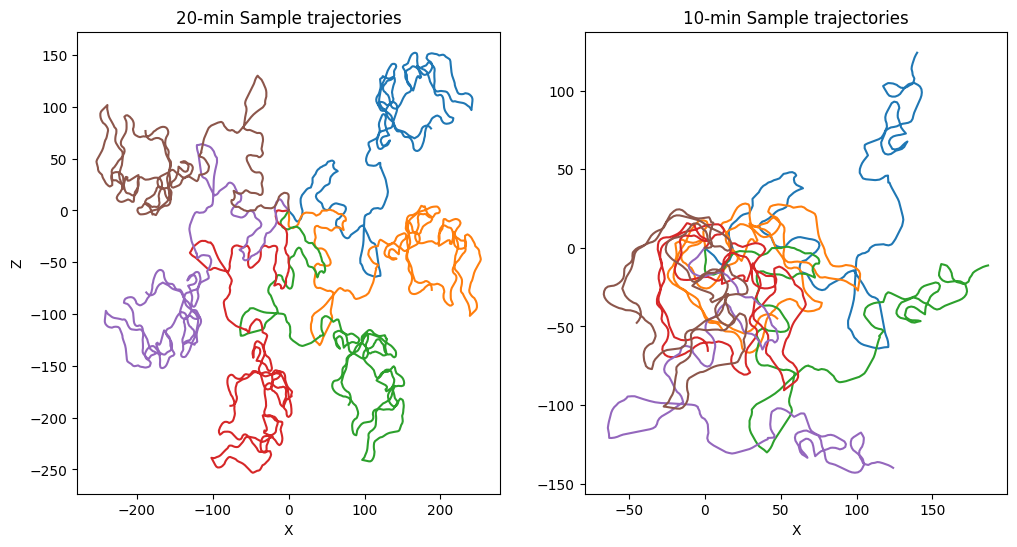

In [21]:
batch_size = 6
scales = [1,2]
x_1, _ = create_batches(dataloader, "uniform", batch_size, scale=scales[0], subsample=True, augmentation=True, shuffle=False)
x_2, _ = create_batches(dataloader, "uniform", batch_size, scale=scales[1], subsample=True, augmentation=True, shuffle=False)
duration_1, duration_2 = x_1.shape[2]//60, x_2.shape[2]//60

# Plot the first 10 trajectories
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i in range(batch_size):
    axes[0].plot(x_1[0, i, :, 0].flatten(), x_1[0, i, :, 1].flatten(), label=f'{duration_1}-min trajectories {i+1}')
    axes[1].plot(x_2[0, i, :, 0].flatten(), x_2[0, i, :, 1].flatten(), label=f'{duration_2}-min trajectories {i+1}')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Z')
axes[0].set_title(f'{duration_1}-min Sample trajectories')
axes[1].set_xlabel('X')
axes[1].set_title(f'{duration_2}-min Sample trajectories')
plt.show()

# Model definition

In [4]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, seq_len):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, dropout=dropout)
        self.dense1 = nn.Linear(hidden_dim, 1)
        self.dense2 = nn.Linear(seq_len,1)
        self.activation = nn.Sigmoid()
        self.seq_len = seq_len

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.permute(1, 0, 2)
        attention_out = self.attention(lstm_out, lstm_out, lstm_out)[0]
        dense_out = self.dense1(attention_out).view(-1, self.seq_len)
        dense_out = self.dense2(dense_out)
        probability = self.activation(dense_out)
        return probability

# Define the model parameters
input_dim = 2  # x and z coordinates
hidden_dim = 64
num_layers = 4
dropout = 0.5

In [ ]:
class TemporalCNN(nn.Module):
    def __init__(self, seq_len, n_channels=2, 
                 conv_params_1 : dict = {"channels" : 8, "kernel_size": 20, "stride": 1},
                 conv_params_2 : dict = {"channels" : 16, "kernel_size": 5, "stride": 1},
                 conv_params_3 : dict = {"channels" : 32, "kernel_size": 3, "stride": 1},
                 conv_params_4 : dict = {"channels" : 64, "kernel_size": 3, "stride": 1},):
    
        super(TemporalCNN, self).__init__()

        def calculate_seq_len(seq_len, kernel_size, stride, padding):
            return (seq_len - kernel_size + 2 * padding) // stride + 1

        # 1 convolution
        channels_1 = conv_params_1["channels"]
        kernel_size_1 = conv_params_1["kernel_size"]
        stride_1 = conv_params_1["stride"]
        self.conv1 = nn.Conv1d(n_channels, out_channels=channels_1, kernel_size=kernel_size_1, stride=stride_1, padding=0)
        self.seq_len = calculate_seq_len(seq_len, kernel_size_1, stride_1, 0)

        self.bn1 = nn.BatchNorm1d(channels_1)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Second convolution
        channels_2 = conv_params_2["channels"]
        kernel_size_2 = conv_params_2["kernel_size"]
        stride_2 = conv_params_2["stride"]
        self.conv2 = nn.Conv1d(channels_1, channels_2, kernel_size=kernel_size_2, stride=stride_2, padding=0)
        self.seq_len = calculate_seq_len(self.seq_len, kernel_size_2, stride_2, 0)

        # BatchNorm       
        self.bn2 = nn.BatchNorm1d(channels_2)

        # Third convolution
        channels_3 = conv_params_3["channels"]
        kernel_size_3 = conv_params_3["kernel_size"]
        stride_3 = conv_params_3["stride"]
        self.conv3 = nn.Conv1d(channels_2, channels_3, kernel_size=kernel_size_3, stride=stride_3, padding=0)
        self.seq_len = calculate_seq_len(self.seq_len, kernel_size_3, stride_3, 0)

        # BatchNorm
        self.bn3 = nn.BatchNorm1d(channels_3)

        # Fourth convolution
        channels_4 = conv_params_4["channels"]
        kernel_size_4 = conv_params_4["kernel_size"]
        stride_4 = conv_params_4["stride"]
        self.conv4 = nn.Conv1d(channels_3, channels_4, kernel_size=kernel_size_4, stride=stride_4, padding=0)
        self.seq_len = calculate_seq_len(self.seq_len, kernel_size_4, stride_4, 0)

        # BatchNorm
        self.bn4 = nn.BatchNorm1d(channels_4)

        # Predictor
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(channels_4, 1)
        self.fc2 = nn.Linear(self.seq_len, 1)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

                    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, n_channels, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.dropout(x)
        x = F.leaky_relu(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, n_channels)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, 1, seq_len)
        x = self.fc2(x).flatten()
        # x = F.sigmoid(x)
        return x.squeeze()

# Training

In [24]:
x_train_clf, y_train_clf = data_setup(dataloader=dataloader,scale=1, batch_size=6, augmentation=True)
x_test_clf, y_test_clf = data_setup(dataloader=dataloader_2024,scale=1, batch_size=9, augmentation=False)
seq_len = x_train_clf.shape[2]

Iterating through dataloader...


100%|██████████| 39/39 [00:35<00:00,  1.10it/s]


Iterating through dataloader...


100%|██████████| 39/39 [00:39<00:00,  1.01s/it]


Trajectory batches shape: torch.Size([102, 6, 1200, 2])
Target batches shape: torch.Size([102, 6])
Iterating through dataloader...


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


Iterating through dataloader...


100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


Trajectory batches shape: torch.Size([2, 9, 1200, 2])
Target batches shape: torch.Size([2, 9])


In [151]:
x_train, y_train = data_setup(dataloader=dataloader,scale=1, batch_size=6, augmentation=True, return_asrs=True)
x_test, y_test = data_setup(dataloader=dataloader_2024,scale=1, batch_size=9, augmentation=False, return_asrs=True)

Iterating through dataloader...


100%|██████████| 39/39 [00:37<00:00,  1.04it/s]


Iterating through dataloader...


100%|██████████| 39/39 [00:36<00:00,  1.07it/s]


Trajectory batches shape: torch.Size([102, 6, 1200, 2])
Target batches shape: torch.Size([102, 6])
Iterating through dataloader...


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


Iterating through dataloader...


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


Trajectory batches shape: torch.Size([2, 9, 1200, 2])
Target batches shape: torch.Size([2, 9])


In [152]:
scaler = MinMaxScaler()
all_asrs = torch.cat((y_train.flatten(), y_test.flatten()), 0)
all_asrs_norm = scaler.fit_transform(all_asrs.reshape(-1,1)).astype(np.float32)
y_train = all_asrs_norm[:y_train.shape[0]*y_train.shape[1]].reshape(y_train.shape)
y_test = all_asrs_norm[y_train.shape[0]*y_train.shape[1]:].reshape(y_test.shape)

In [210]:
model = LSTMWithAttention(input_dim, hidden_dim, num_layers, dropout, seq_len)

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
C:\Users\TomFi\AppData\Local\Temp\ipykernel_3940\4226674619.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu}$, $\sigma={std}$')
C:\Users\TomFi\AppData\Local\Temp\ipykernel_3940\4226674619.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu}$, $\sigma={std}$')


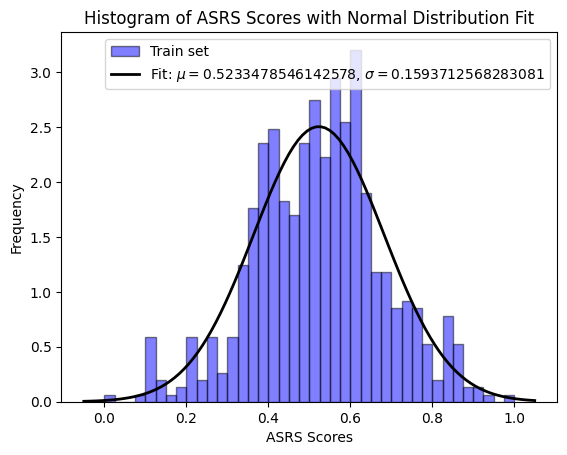

In [168]:
from scipy.stats import norm

# Fit a normal distribution to the data
mu, std = norm.fit(y_train.flatten())

# Plot the histogram
plt.hist(y_train.flatten(), bins=40, alpha=0.5, label='Train set', color='blue', edgecolor='black', density=True)
# plt.hist(y_test.flatten(), bins=40, alpha=0.5, label='Test set', color='red', edgecolor='black', density=True)

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu}$, $\sigma={std}$')

# Add labels and title
plt.xlabel('ASRS Scores')
plt.ylabel('Frequency')
plt.title('Histogram of ASRS Scores with Normal Distribution Fit')
plt.legend()
plt.show()

In [258]:
# Define the custom MSE loss function
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_var = 0.5):
        super(CustomMSELoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.KL = nn.KLDivLoss()
        self.lambda_var = lambda_var

    def forward(self, outputs, targets):
        mse_loss = self.mse_loss(outputs, targets)
        entropy = -outputs * torch.log(outputs) - (1 - outputs) * torch.log(1 - outputs)
        variance_pen = torch.abs(torch.var(outputs) - 0.2)
        kl = torch.exp(self.KL(outputs, targets))
        return mse_loss + self.lambda_var * variance_pen

In [254]:
def train(model, x_train, y_train, x_test, y_test, criterion, num_epochs : int = 100, learning_rate : float = 0.001,
          monitor_gradients : bool = False, lambda_var : float = 0.1):
    # Define the loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize plot
    plt.ion()
    fig, ax = plt.subplots(figsize=(12, 6))
    losses = []
    val_losses = []

    # Example training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in range(x_train.shape[0]):
            x_train_batch = x_train[batch]
            y_train_batch = y_train[batch]
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_train_batch)
            loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/x_train.shape[0]
            

            # Monitor gradients
            if monitor_gradients : 
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        print(f'{name}: {param.grad.abs().mean()}')

        # add validation on test set
        with torch.no_grad():
            model.eval()
            outputs = []
            for batch in range(x_test.shape[0]):
                x_test_batch = x_test[batch]
                y_test_batch = y_test[batch]            
                outputs.append(model(x_test_batch).squeeze().detach().numpy())
            val_loss = criterion(torch.tensor(outputs).squeeze(), torch.tensor(y_test).squeeze()).item()


        print(f'Epoch {epoch+1}/{num_epochs}, batch {batch+1}/{x_train.shape[0]}, Loss: {train_loss}, Val Loss: {val_loss}')
        
        # Dynamic plot to showcase the evolution of the loss
        losses.append(train_loss)
        val_losses.append(val_loss)
        ax.clear()
        ax.plot(losses, label='Train Loss', c = 'navy')
        ax.plot(val_losses, label='Validation Loss', c= 'r')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training and Validation Loss')
        ax.legend()
        display.clear_output(wait=True)
        display.display(fig) 

    plt.ioff()
    plt.close()

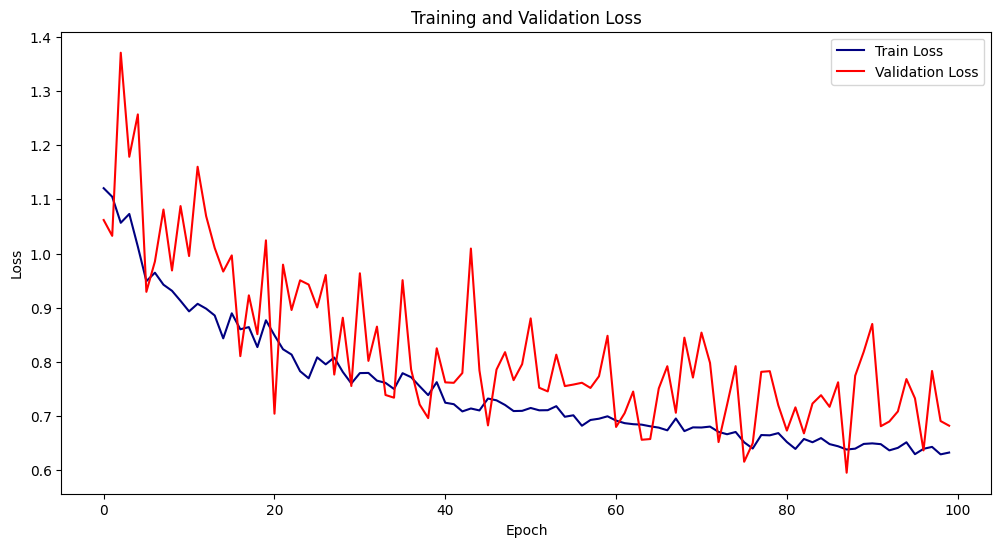

In [ ]:
criterion_clf = nn.BCELoss()
train(temporal_cnn, x_train, y_train_clf, x_test, y_test_clf, criterion = criterion_clf, num_epochs=100, learning_rate=1e-05, monitor_gradients=False)

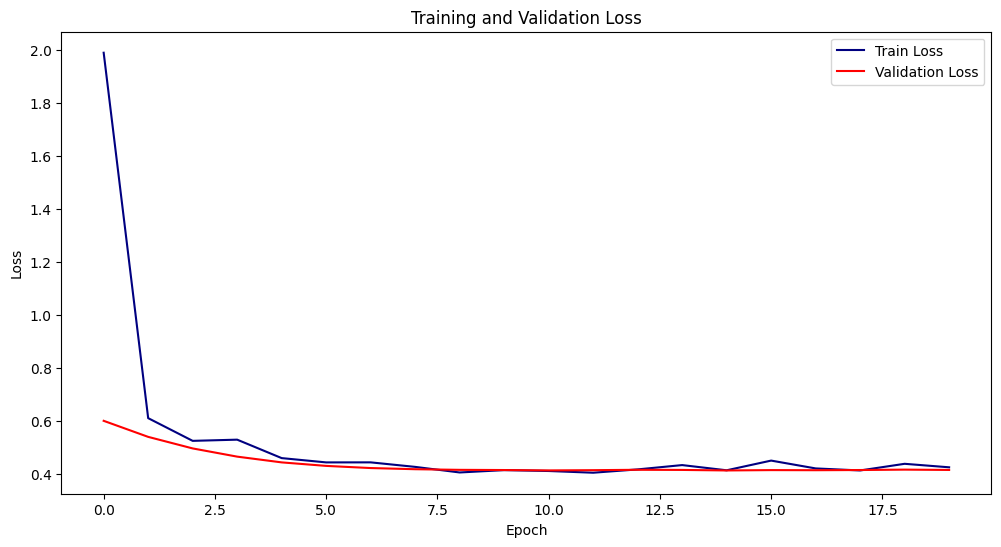

In [259]:
conv_params_1 = {"channels" : 32, "kernel_size": 20, "stride": 1}
conv_params_2 = {"channels" : 64, "kernel_size": 10, "stride": 5}
conv_params_3 = {"channels" : 128, "kernel_size": 10, "stride": 5}
conv_params_4 = {"channels" : 256, "kernel_size": 5, "stride": 3}
temporal_cnn_deep = TemporalCNN(seq_len, n_channels=2, conv_params_1=conv_params_1, conv_params_2=conv_params_2, conv_params_3=conv_params_3, conv_params_4=conv_params_4)
torchsummary.summary(temporal_cnn_deep, (seq_len, 2))
criterion = CustomMSELoss(lambda_var=2)
train(temporal_cnn_deep, x_train, y_train, x_test, y_test, criterion = criterion, num_epochs=20, learning_rate=1e-03, monitor_gradients=True)

In [260]:
torchsummary.summary(temporal_cnn_deep, (seq_len, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 1181]           1,312
       BatchNorm1d-2             [-1, 32, 1181]              64
            Conv1d-3              [-1, 64, 235]          20,544
       BatchNorm1d-4              [-1, 64, 235]             128
            Conv1d-5              [-1, 128, 46]          82,048
       BatchNorm1d-6              [-1, 128, 46]             256
            Conv1d-7              [-1, 256, 14]         164,096
       BatchNorm1d-8              [-1, 256, 14]             512
           Dropout-9              [-1, 256, 14]               0
           Linear-10                [-1, 14, 1]             257
           Linear-11                 [-1, 1, 1]              15
Total params: 269,232
Trainable params: 269,232
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

Mean Squared Error: 0.01585906185209751


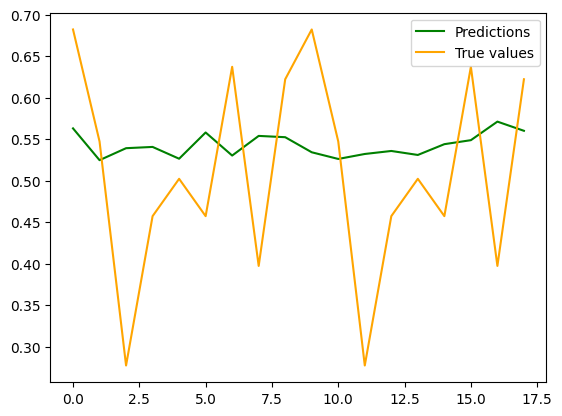

(0.015859062,
 array([0.5631469 , 0.52485096, 0.53927094, 0.5407987 , 0.526586  ,
        0.5582052 , 0.53041136, 0.5540704 , 0.5525118 , 0.53435034,
        0.5263062 , 0.53230137, 0.53592575, 0.5311164 , 0.54410917,
        0.54893136, 0.57128936, 0.56022716], dtype=float32))

In [261]:
eval_score(temporal_cnn_deep, x_test, y_test)

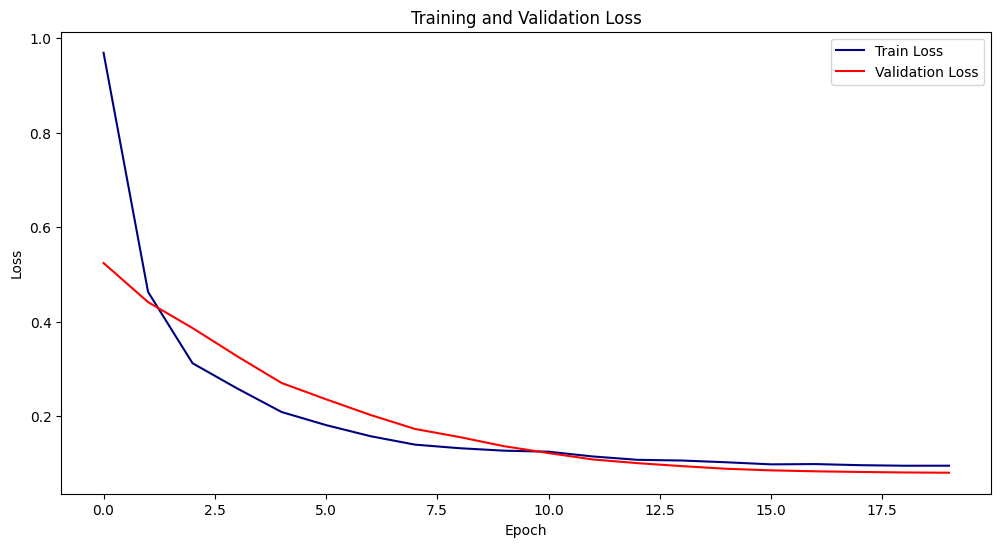

In [ ]:
best_params = {
    '1_kernel_size': 10,
    'first_channels': 16,
    'first_stride': 5,
    'second_kernel_size': 5,
    'second_stride': 4,
    'lambda_var': 0.9639937540053819,
    'learning_rate': 0.0005278356017203062,
    'num_epochs': 83,
}
conv_params_1 = {"channels": best_params['first_channels'], "kernel_size": best_params['first_kernel_size'], "stride": best_params['first_stride'], "padding": 0}
conv_params_2 = {"channels": best_params['first_channels']*2, "kernel_size": best_params['second_kernel_size'], "stride": best_params['second_stride'], "padding": 0}
model = TemporalCNN(conv_params_1=conv_params_1, conv_params_2=conv_params_2, seq_len=seq_len)
torchsummary.summary(model, (seq_len, 2))
criterion = CustomMSELoss(lambda_var=4.5)
train(model, x_train, y_train, x_test, y_test, criterion = criterion, num_epochs=20, learning_rate=1e-03, monitor_gradients=False)


Mean Squared Error: 0.017103716731071472


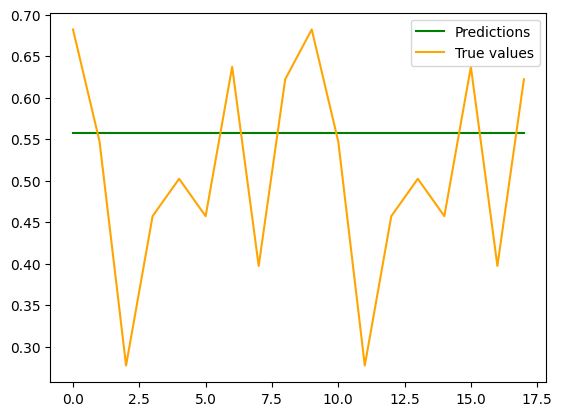

In [233]:
mse, ouputs = eval_score(model, x_test, y_test)

In [ ]:
import optuna

# Define the objective function
def objective(trial):
    # Define the hyperparameters to be optimized
    kernel_size_2 = trial.suggest_int('kernel_size_1', 5, 20)
    stride_2 = trial.suggest_int('stride_1', 1, 5)
    lambda_var = trial.suggest_float('lambda_var', 0.0, 10.0)

    conv_params_1 = {"channels": 16, "kernel_size": 20, "stride": 1, "padding": 0}
    conv_params_2 = {"channels": 32, "kernel_size": 5, "stride": 5, "padding": 0}
    conv_params_3 = {"channels": 64, "kernel_size": 3, "stride": 3, "padding": 0}
    conv_params_4 = {"channels": 128, "kernel_size": 3, "stride": 3, "padding": 0}

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log = True)
    num_epochs = 50
    
    # Define the model
    model = TemporalCNN(conv_params_1=conv_params_1, conv_params_2=conv_params_2, seq_len=seq_len)
    torchsummary.summary(model, (seq_len, 2))

    # Define the loss function and optimizer
    criterion = CustomMSELoss(lambda_var=lambda_var)
    criterion_eval = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in range(x_train.shape[0]):
            x_train_batch = x_train[batch]
            y_train_batch = y_train[batch]
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_train_batch)
            loss = criterion(outputs.squeeze(), torch.tensor(y_train_batch, dtype=torch.float32))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/x_train.shape[0]

        # add validation on test set
        with torch.no_grad():
            model.eval()
            outputs = []
            for batch in range(x_test.shape[0]):
                x_test_batch = x_test[batch]
                y_test_batch = y_test[batch]            
                outputs.append(model(x_test_batch).squeeze().detach().numpy())
            val_loss = criterion_eval(torch.tensor(outputs).squeeze(), torch.tensor(y_test).squeeze()).item()
            torch.save(model.state_dict(), f'model_checkpoints/best_model_{str(trial.params.items())}.pth')

    return val_loss

# Example usage
# Assuming x_data and y_data are already defined
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-11-29 15:19:27,078] A new study created in memory with name: no-name-b891e2a4-6eb2-4a1f-9a59-d0ec03ab0c25


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:19:40,407] Trial 0 finished with value: 0.14225167036056519 and parameters: {'lambda_var': 3.8793065141536855, 'learning_rate': 7.152813471099371e-05, 'num_epochs': 55}. Best is trial 0 with value: 0.14225167036056519.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:19:55,067] Trial 1 finished with value: 0.017811588943004608 and parameters: {'lambda_var': 6.946138884442654, 'learning_rate': 0.03320626387150118, 'num_epochs': 61}. Best is trial 1 with value: 0.017811588943004608.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:20:16,219] Trial 2 finished with value: 0.01925523951649666 and parameters: {'lambda_var': 4.814311643919603, 'learning_rate': 0.00018480551460960505, 'num_epochs': 88}. Best is trial 1 with value: 0.017811588943004608.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:20:24,295] Trial 3 finished with value: 0.2508609890937805 and parameters: {'lambda_var': 1.1305245887617832, 'learning_rate': 3.5888526909935747e-05, 'num_epochs': 34}. Best is trial 1 with value: 0.017811588943004608.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:20:40,644] Trial 4 finished with value: 0.01528818067163229 and parameters: {'lambda_var': 9.112237756540326, 'learning_rate': 0.003942632532809816, 'num_epochs': 68}. Best is trial 4 with value: 0.01528818067163229.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:20:54,398] Trial 5 finished with value: 0.017108939588069916 and parameters: {'lambda_var': 7.062835298102201, 'learning_rate': 0.025012748992192805, 'num_epochs': 59}. Best is trial 4 with value: 0.01528818067163229.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:20:59,739] Trial 6 finished with value: 0.5618062615394592 and parameters: {'lambda_var': 7.969732404694724, 'learning_rate': 1.2586487868151615e-05, 'num_epochs': 23}. Best is trial 4 with value: 0.01528818067163229.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:21:22,519] Trial 7 finished with value: 0.03172574192285538 and parameters: {'lambda_var': 2.6502165608646475, 'learning_rate': 0.0007492595114604411, 'num_epochs': 95}. Best is trial 4 with value: 0.01528818067163229.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:21:28,387] Trial 8 finished with value: 0.015436223708093166 and parameters: {'lambda_var': 9.555583667094945, 'learning_rate': 0.006390684300533478, 'num_epochs': 25}. Best is trial 4 with value: 0.01528818067163229.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:21:42,770] Trial 9 finished with value: 0.03735322505235672 and parameters: {'lambda_var': 0.9251196025246544, 'learning_rate': 0.016210845719156725, 'num_epochs': 62}. Best is trial 4 with value: 0.01528818067163229.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:22:01,227] Trial 10 finished with value: 0.014906112104654312 and parameters: {'lambda_var': 9.737799905594743, 'learning_rate': 0.002279385652267507, 'num_epochs': 79}. Best is trial 10 with value: 0.014906112104654312.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:22:19,071] Trial 11 finished with value: 0.015007734298706055 and parameters: {'lambda_var': 9.995088297044807, 'learning_rate': 0.0025833645575973297, 'num_epochs': 77}. Best is trial 10 with value: 0.014906112104654312.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:22:37,555] Trial 12 finished with value: 0.015035171061754227 and parameters: {'lambda_var': 9.958399224152862, 'learning_rate': 0.0011126294419951238, 'num_epochs': 80}. Best is trial 10 with value: 0.014906112104654312.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:22:55,672] Trial 13 finished with value: 0.015410802327096462 and parameters: {'lambda_var': 7.905670583739195, 'learning_rate': 0.0012283663285532753, 'num_epochs': 78}. Best is trial 10 with value: 0.014906112104654312.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:23:05,862] Trial 14 finished with value: 0.03017120622098446 and parameters: {'lambda_var': 6.103593538286785, 'learning_rate': 0.08131816260656903, 'num_epochs': 44}. Best is trial 10 with value: 0.014906112104654312.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:23:23,367] Trial 15 finished with value: 0.01537519320845604 and parameters: {'lambda_var': 8.453319751978517, 'learning_rate': 0.00034860291027392464, 'num_epochs': 75}. Best is trial 10 with value: 0.014906112104654312.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:23:46,156] Trial 16 finished with value: 0.017619313672184944 and parameters: {'lambda_var': 6.119279425031229, 'learning_rate': 0.004078711365110578, 'num_epochs': 99}. Best is trial 10 with value: 0.014906112104654312.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:23:48,610] Trial 17 finished with value: 0.014864504337310791 and parameters: {'lambda_var': 9.971299205428714, 'learning_rate': 0.0030461444032031646, 'num_epochs': 10}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:23:50,973] Trial 18 finished with value: 0.015849003568291664 and parameters: {'lambda_var': 8.575756397624868, 'learning_rate': 0.012387966841202443, 'num_epochs': 10}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:24:02,078] Trial 19 finished with value: 0.01594613865017891 and parameters: {'lambda_var': 2.9491723763589226, 'learning_rate': 0.0003676555690088239, 'num_epochs': 48}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:24:05,628] Trial 20 finished with value: 0.015791988000273705 and parameters: {'lambda_var': 6.954294837111892, 'learning_rate': 0.0021096986033458205, 'num_epochs': 15}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:24:27,152] Trial 21 finished with value: 0.014991311356425285 and parameters: {'lambda_var': 9.989644484459195, 'learning_rate': 0.002423046456453653, 'num_epochs': 88}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:24:48,523] Trial 22 finished with value: 0.015483210794627666 and parameters: {'lambda_var': 8.74751806304259, 'learning_rate': 0.006426778877557726, 'num_epochs': 91}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:25:08,546] Trial 23 finished with value: 0.015025973320007324 and parameters: {'lambda_var': 9.302184050578333, 'learning_rate': 0.000599151119327396, 'num_epochs': 85}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:25:25,651] Trial 24 finished with value: 0.046071458607912064 and parameters: {'lambda_var': 7.803636218803709, 'learning_rate': 0.0018138757382924072, 'num_epochs': 71}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:25:34,708] Trial 25 finished with value: 0.015597645193338394 and parameters: {'lambda_var': 9.282482711759423, 'learning_rate': 0.008993614675051184, 'num_epochs': 38}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:25:57,157] Trial 26 finished with value: 0.02286519855260849 and parameters: {'lambda_var': 5.150983934095101, 'learning_rate': 0.0001606959524068931, 'num_epochs': 86}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:26:23,117] Trial 27 finished with value: 0.024787893518805504 and parameters: {'lambda_var': 9.921792415751336, 'learning_rate': 0.003368163415906005, 'num_epochs': 97}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:26:40,579] Trial 28 finished with value: 0.01936107873916626 and parameters: {'lambda_var': 7.745380484841609, 'learning_rate': 0.05460126302459338, 'num_epochs': 67}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:26:52,355] Trial 29 finished with value: 0.12134797126054764 and parameters: {'lambda_var': 8.883591249914614, 'learning_rate': 7.15923843146265e-05, 'num_epochs': 45}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:27:06,480] Trial 30 finished with value: 0.018050484359264374 and parameters: {'lambda_var': 5.61320558944594, 'learning_rate': 0.0017457201834280543, 'num_epochs': 53}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:27:27,396] Trial 31 finished with value: 0.01872098445892334 and parameters: {'lambda_var': 9.711817003273806, 'learning_rate': 0.003410621857755765, 'num_epochs': 79}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:27:49,418] Trial 32 finished with value: 0.015009446069598198 and parameters: {'lambda_var': 9.850755950555188, 'learning_rate': 0.001963509102602966, 'num_epochs': 83}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:28:13,366] Trial 33 finished with value: 0.01578836888074875 and parameters: {'lambda_var': 8.43802073335543, 'learning_rate': 0.005862388511475729, 'num_epochs': 92}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:28:32,698] Trial 34 finished with value: 0.024770382791757584 and parameters: {'lambda_var': 3.7793946199681763, 'learning_rate': 0.0004084491982178183, 'num_epochs': 74}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:28:49,622] Trial 35 finished with value: 0.01558057963848114 and parameters: {'lambda_var': 9.25169472176885, 'learning_rate': 0.01858131623453781, 'num_epochs': 65}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:29:04,268] Trial 36 finished with value: 0.015851527452468872 and parameters: {'lambda_var': 7.369283189310258, 'learning_rate': 0.0007576987638941595, 'num_epochs': 55}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:29:28,612] Trial 37 finished with value: 0.015358307398855686 and parameters: {'lambda_var': 8.367737116735075, 'learning_rate': 0.0026667835791975712, 'num_epochs': 91}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:29:37,245] Trial 38 finished with value: 0.06788526475429535 and parameters: {'lambda_var': 9.11677457783689, 'learning_rate': 0.0001727051681493805, 'num_epochs': 32}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:29:56,300] Trial 39 finished with value: 0.02024030312895775 and parameters: {'lambda_var': 0.2957059238284696, 'learning_rate': 0.0012851174073526467, 'num_epochs': 72}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:30:17,641] Trial 40 finished with value: 0.01780492439866066 and parameters: {'lambda_var': 6.367425098962158, 'learning_rate': 0.0095372091283535, 'num_epochs': 83}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:30:41,581] Trial 41 finished with value: 0.015154101885855198 and parameters: {'lambda_var': 9.9395867818577, 'learning_rate': 0.004251035533286418, 'num_epochs': 88}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:31:03,231] Trial 42 finished with value: 0.014952344819903374 and parameters: {'lambda_var': 9.525773763630943, 'learning_rate': 0.0020727089153782874, 'num_epochs': 82}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:31:19,302] Trial 43 finished with value: 0.08682786673307419 and parameters: {'lambda_var': 9.443714552614011, 'learning_rate': 0.0007651328199041119, 'num_epochs': 60}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:31:40,075] Trial 44 finished with value: 0.015563057735562325 and parameters: {'lambda_var': 8.915372600660014, 'learning_rate': 0.005583057233326884, 'num_epochs': 77}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:32:02,514] Trial 45 finished with value: 0.015423135831952095 and parameters: {'lambda_var': 8.21704681082579, 'learning_rate': 0.002611426806251071, 'num_epochs': 82}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[I 2024-11-29 15:32:27,873] Trial 46 finished with value: 0.015064151957631111 and parameters: {'lambda_var': 9.526899885997837, 'learning_rate': 0.0013885407186711707, 'num_epochs': 94}. Best is trial 17 with value: 0.014864504337310791.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 239]             336
       BatchNorm1d-2              [-1, 16, 239]              32
            Conv1d-3               [-1, 32, 47]           2,592
       BatchNorm1d-4               [-1, 32, 47]              64
           Dropout-5               [-1, 32, 47]               0
            Linear-6                [-1, 47, 1]              33
            Linear-7                 [-1, 1, 1]              48
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


[W 2024-11-29 15:32:34,672] Trial 47 failed with parameters: {'lambda_var': 9.984246271257028, 'learning_rate': 0.008913697475099272, 'num_epochs': 69} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\TomFi\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\TomFi\AppData\Local\Temp\ipykernel_3940\687408602.py", line 46, in objective
    optimizer.step()
  File "c:\Users\TomFi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\optimizer.py", line 487, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\TomFi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\optimizer.py", line 91, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\TomFi\AppData\Local\Programs

KeyboardInterrupt: 

# Evaluating models

In [20]:
def eval_binaryclass(model, x_test, y_test):
    outputs = []
    for batch in range(x_test.shape[0]):
        x_test_batch = x_test[batch]
        outputs.append(model(x_test_batch).squeeze().detach().numpy())
    outputs = np.array(outputs).flatten()
    test_HP_adhd = np.array(y_test).flatten()
    threshold = np.arange(0.02, 0.98, 0.02)
    accuracy, precision, recall = [], [], []
    for t in threshold:
        tp = np.sum((outputs > t) & (test_HP_adhd == 1)) + 1e-10
        tn = np.sum((outputs <= t) & (test_HP_adhd == 0))+ 1e-10
        fp = np.sum((outputs > t) & (test_HP_adhd == 0))+ 1e-10
        fn = np.sum((outputs <= t) & (test_HP_adhd == 1))+ 1e-10
        # print(f"TP : {tp}, TN : {tn}, FP : {fp}, FN : {fn}")
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    f1 = 2 * np.array(precision) * np.array(recall) / (np.array(precision) + np.array(recall))
    plt.plot(threshold, precision, label = 'Precision')
    plt.plot(threshold, recall, label = 'Recall')
    plt.plot(threshold, f1, label = 'F1')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Result metrics vs Threshold')
    plt.legend()
    plt.show()

    return f1, outputs


def eval_score(model, x_test, y_test):
    outputs = []
    for batch in range(x_test.shape[0]):
        x_test_batch = x_test[batch]
        outputs.append(model(x_test_batch).squeeze().detach().numpy())
    outputs = np.array(outputs).flatten()
    test_HP_adhd = np.array(y_test).flatten()
    mse = np.mean((outputs - test_HP_adhd) ** 2)
    print(f'Mean Squared Error: {mse}')
    # plot the results
    plt.plot(outputs, label='Predictions', c = 'g')
    plt.plot(test_HP_adhd, label='True values', c = 'orange')
    plt.legend()
    plt.show()
    return mse, outputs

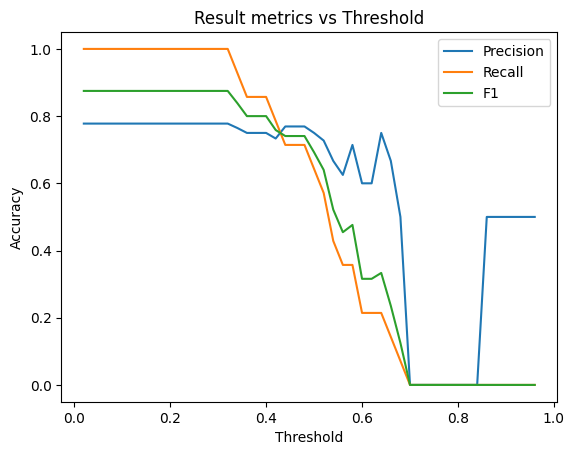

In [21]:
f1, outputs = eval_binaryclass(temporal_cnn, x_test, y_test_clf)

In [33]:
outputs

array([0.5263034 , 0.54728174, 0.8492214 , 0.3434212 , 0.6829511 ,
       0.4821355 , 0.67796165, 0.62352216, 0.41273203, 0.32262534,
       0.433859  , 0.4364097 , 0.50679237, 0.5998699 , 0.534154  ,
       0.64250326, 0.5615466 , 0.58089375], dtype=float32)

Mean Squared Error: 0.28585657477378845


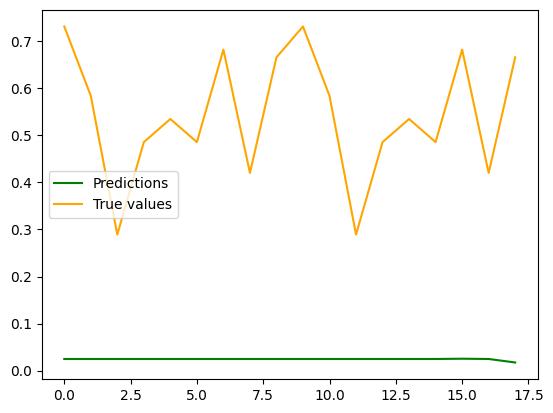

In [110]:
mse, ouputs = eval_score(temporal_cnn, x_test, y_test)

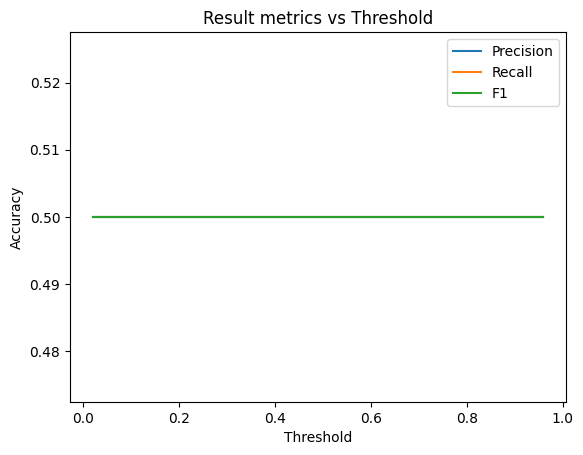

In [ ]:
f1 = eval_binaryclass(temporal_cnn, x_test, y_test)

In [94]:
id_threshold = np.argmax(f1)
max_f1 = f1[id_threshold]
print(f"Best threshold : {id_threshold * 0.02 + 0.02}, achieving F1 score of {max_f1}")

Best threshold : 0.02, achieving F1 score of 0.5


Mean Squared Error: 0.01814792864024639


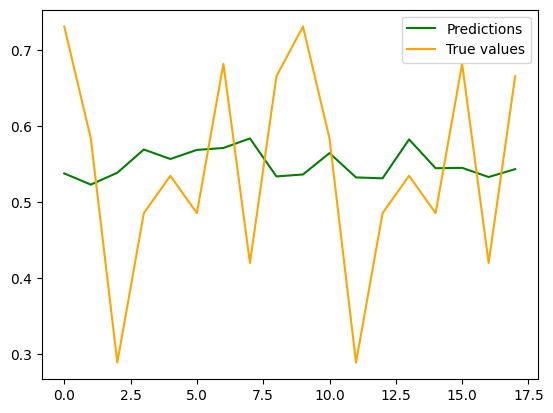

(0.018147929,
 array([0.53808814, 0.5233404 , 0.5389308 , 0.56955785, 0.55707836,
        0.5690302 , 0.57157224, 0.58412355, 0.53411233, 0.53669465,
        0.5648333 , 0.53282344, 0.53162026, 0.582874  , 0.5449254 ,
        0.5454049 , 0.5333208 , 0.5437301 ], dtype=float32))

In [134]:
eval_score(model, x_test, y_test)